<a href="https://colab.research.google.com/github/harshjoshi23/CamVid-obj-segmentation/blob/main/Camvid_usingScheduler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Attempt 4

## Imports

In [51]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

from segmentation_models_pytorch.utils.losses import DiceLoss


# Suppressing warnings for cleaner notebook presentation
import warnings
warnings.filterwarnings("ignore")

In [52]:


# Path to the dataset and class dictionary
base_path = '/content/drive/My Drive/CamVid_Actual'
class_dict_path = os.path.join(base_path, "class_dict.csv")


## Paths and class dictionary

In [53]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:


# Load class dictionary
class_dict = pd.read_csv(class_dict_path)
print(class_dict.head())
# Color mapping from CSV
color_to_class = {tuple(row[['r', 'g', 'b']].values): idx for idx, row in class_dict.iterrows()}
class_to_color = {idx: tuple(row[['r', 'g', 'b']].values) for idx, row in class_dict.iterrows()}



        name    r    g    b
0     Animal   64  128   64
1    Archway  192    0  128
2  Bicyclist    0  128  192
3     Bridge    0  128   64
4   Building  128    0    0


In [55]:
# Dataset paths
train_images_path = sorted([os.path.join(base_path, "train", x) for x in os.listdir(os.path.join(base_path, "train"))])
train_labels_path = sorted([os.path.join(base_path, "train_labels", x) for x in os.listdir(os.path.join(base_path, "train_labels"))])
val_images_path = sorted([os.path.join(base_path, "val", x) for x in os.listdir(os.path.join(base_path, "val"))])
val_labels_path = sorted([os.path.join(base_path, "val_labels", x) for x in os.listdir(os.path.join(base_path, "val_labels"))])

# Example transformation and dataset class
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


## Defining thecamVidDataset Class

In [56]:
class CamVidDataset(Dataset):
    def __init__(self, images_path, labels_path, transform=None, label_transform=None):
        self.images_path = images_path
        self.labels_path = labels_path
        self.transform = transform
        self.label_transform = label_transform  # Separate transform for labels

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, idx):
        image = Image.open(self.images_path[idx]).convert("RGB")
        label = Image.open(self.labels_path[idx])

        if self.transform:
            image = self.transform(image)

        if self.label_transform:
            label = self.label_transform(label)  # Apply label-specific transformations

        # Convert label to class indices using color mapping
        label = np.array(label, dtype=np.int32)  # Ensure using int32 for label indexing
        mask = np.zeros((label.shape[0], label.shape[1]), dtype=np.int64)
        for rgb, class_id in color_to_class.items():
            match = (label == np.array(rgb, dtype=np.int32)).all(axis=-1)
            mask[match] = class_id

        label = torch.from_numpy(mask)
        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

label_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST)  # Resize labels to match image size
])

train_dataset = CamVidDataset(train_images_path, train_labels_path, transform, label_transform)
val_dataset = CamVidDataset(val_images_path, val_labels_path, transform, label_transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)


Image batch shape: torch.Size([4, 3, 256, 256])
Label batch shape: torch.Size([4, 256, 256])


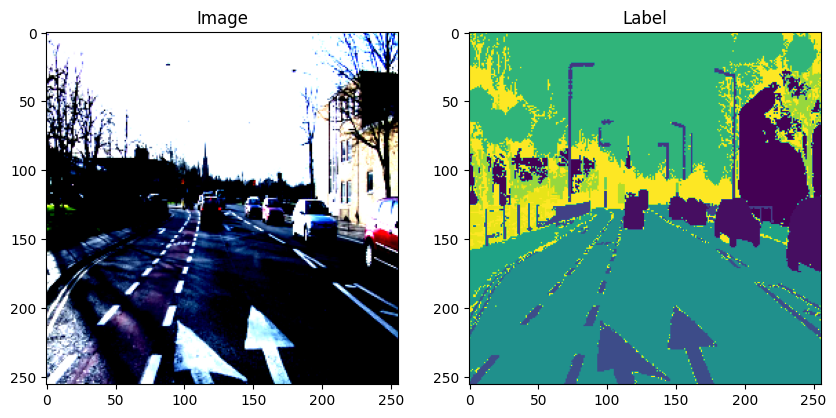

In [57]:
# Quick check
for images, labels in train_loader:
    print(f"Image batch shape: {images.size()}")
    print(f"Label batch shape: {labels.size()}")
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.imshow(images[0].permute(1, 2, 0).numpy())
    plt.title("Image")
    plt.subplot(122)
    plt.imshow(labels[0].numpy())
    plt.title("Label")
    plt.show()
    break

## Code for Model :

Unet Architecture :

In [58]:
import torch
import torch.nn as nn

# class DoubleConv(nn.Module):
#     """(convolution => [BN] => ReLU) * 2"""
#     def __init__(self, in_channels, out_channels):
#         super(DoubleConv, self).__init__()
#         self.double_conv = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, 3, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, 3, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True)
#         )

#     def forward(self, x):
#         return self.double_conv(x)


#  # Using droputs : better results above code also right but I feel need to adjust lr's / tune hyperparams


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_prob=0.5):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_prob),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = DoubleConv(64, 128)
        self.down2 = DoubleConv(128, 256)
        self.down3 = DoubleConv(256, 512)
        self.down4 = DoubleConv(512, 512)
        self.up1 = DoubleConv(1024, 256)
        self.up2 = DoubleConv(512, 128)
        self.up3 = DoubleConv(256, 64)
        self.up4 = DoubleConv(128, 64)
        self.outc = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(torch.cat([x4, x5], dim=1))
        x = self.up2(torch.cat([x3, x], dim=1))
        x = self.up3(torch.cat([x2, x], dim=1))
        x = self.up4(torch.cat([x1, x], dim=1))
        logits = self.outc(x)
        return logits

# Model initialization
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(n_channels=3, n_classes=len(class_dict)).to(device)


## Loss Fn and optimizer :

In [59]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [60]:
# Check for acc ~ once later only

## Model training Updated

Best Results

Using Scheduler

In [61]:
# def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, scheduler=None):
#     best_val_loss = float('inf')

#     for epoch in range(num_epochs):
#         model.train()
#         train_loss = 0
#         correct_train = 0
#         total_train = 0

#         for images, masks in train_loader:
#             images, masks = images.to(device), masks.to(device)
#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, masks)
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item()

#             _, predicted = torch.max(outputs, 1)
#             total_train += masks.numel()
#             correct_train += (predicted == masks).sum().item()

#         train_accuracy = 100 * correct_train / total_train

#         model.eval()
#         val_loss = 0
#         correct_val = 0
#         total_val = 0
#         with torch.no_grad():
#             for images, masks in val_loader:
#                 images, masks = images.to(device), masks.to(device)
#                 outputs = model(images)
#                 loss = criterion(outputs, masks)
#                 val_loss += loss.item()

#                 _, predicted = torch.max(outputs, 1)
#                 total_val += masks.numel()
#                 correct_val += (predicted == masks).sum().item()

#         val_accuracy = 100 * correct_val / total_val

#         if scheduler:
#             scheduler.step(val_loss)

#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             torch.save(model.state_dict(), 'best_model.pth')
#             print("Saved Best Model")

#         print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss / len(train_loader):.3f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss / len(val_loader):.3f}, Val Acc: {val_accuracy:.2f}%')



In [64]:
# Baseline:

In [72]:
#Updated Training Function with Epoch Feedback and Accuracy
import torch

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += masks.nelement()
            correct_train += predicted.eq(masks.data).sum().item()

        train_accuracy = 100 * correct_train / total_train

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += masks.nelement()
                correct_val += predicted.eq(masks.data).sum().item()

        val_accuracy = 100 * correct_val / total_val

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss / len(train_loader):.3f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss / len(val_loader):.3f}, Val Acc: {val_accuracy:.2f}%')

train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)


OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB. GPU 

## LF and iptimizer update :

Using Dice Loss

In [66]:
from segmentation_models_pytorch.utils.losses import DiceLoss


In [67]:
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.ce_loss = nn.CrossEntropyLoss()
        # Assuming DiceLoss is expected to work without the `mode` parameter
        self.dice_loss = DiceLoss()

    def forward(self, outputs, targets):
        loss = self.alpha * self.ce_loss(outputs, targets) + self.beta * self.dice_loss(outputs, targets)
        return loss


In [68]:
# New Tr loop :

In [69]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, scheduler=None):
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_train += masks.numel()
            correct_train += (predicted == masks).sum().item()

        train_accuracy = 100 * correct_train / total_train

        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_val += masks.numel()
                correct_val += (predicted == masks).sum().item()

        val_accuracy = 100 * correct_val / total_val

        if scheduler:
            scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print("Saved Best Model")

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss / len(train_loader):.3f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss / len(val_loader):.3f}, Val Acc: {val_accuracy:.2f}%')


In [71]:
# Define and instantiate the model, criterion, optimizer, and scheduler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(n_channels=3, n_classes=len(class_dict)).to(device)

# Combined loss function
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.ce_loss = nn.CrossEntropyLoss()
        self.dice_loss = DiceLoss()

    def forward(self, outputs, targets):
        loss = self.alpha * self.ce_loss(outputs, targets) + self.beta * self.dice_loss(outputs, targets)
        return loss

criterion = CombinedLoss(alpha=0.5, beta=0.5)

# Optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, scheduler=scheduler)


OutOfMemoryError: CUDA out of memory. Tried to allocate 128.00 MiB. GPU 

In [ ]:
baseline

Wait

Feel the accuracy is good afre using the scheduer wont test for below as it's taking 1 hour + for 10 epoches and then I am not able to eval on free colab

In [25]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, scheduler=scheduler)


Saved Best Model
Epoch 1/10, Train Loss: 1.821, Train Acc: 55.80%, Val Loss: 1.666, Val Acc: 54.37%
Saved Best Model
Epoch 2/10, Train Loss: 1.265, Train Acc: 62.53%, Val Loss: 1.267, Val Acc: 63.24%
Saved Best Model
Epoch 3/10, Train Loss: 1.131, Train Acc: 66.12%, Val Loss: 1.119, Val Acc: 66.48%
Saved Best Model
Epoch 4/10, Train Loss: 1.078, Train Acc: 67.70%, Val Loss: 1.048, Val Acc: 69.11%
Saved Best Model
Epoch 5/10, Train Loss: 1.042, Train Acc: 68.76%, Val Loss: 1.019, Val Acc: 69.16%
Saved Best Model
Epoch 6/10, Train Loss: 0.990, Train Acc: 70.42%, Val Loss: 1.011, Val Acc: 69.13%


KeyboardInterrupt: 

In [ ]:
# breakpoint

In [ ]:
# from torch.optim.lr_scheduler import ReduceLROnPlateau

# optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, scheduler=scheduler)


In [ ]:
# breakpoint

In [ ]:
# from torch.optim.lr_scheduler import ReduceLROnPlateau

# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, scheduler=scheduler)


In [ ]:
# breakpoint

## Model Eval :


In [ ]:
# Model evaluation on a separate test set
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_test += masks.numel()
            correct_test += (predicted == masks).sum().item()

    test_accuracy = 100 * correct_test / total_test
    print(f'Test Loss: {test_loss / len(test_loader):.3f}, Test Accuracy: {test_accuracy:.2f}%')

evaluate_model(model, test_loader, criterion)


In [ ]:
breakpoint

## Other models tested

good baseline model

In [ ]:
#Updated Training Function with Epoch Feedback and Accuracy
import torch

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += masks.nelement()
            correct_train += predicted.eq(masks.data).sum().item()

        train_accuracy = 100 * correct_train / total_train

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += masks.nelement()
                correct_val += predicted.eq(masks.data).sum().item()

        val_accuracy = 100 * correct_val / total_val

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss / len(train_loader):.3f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss / len(val_loader):.3f}, Val Acc: {val_accuracy:.2f}%')

train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)
